# Bullet Bonds

The definition of a bullet bond is very simple - it's a bond that repays all the principal at the end of the period. Here's an example of the cash flows from a bullet bond: 




[500.0, 500.0, 1500.0]


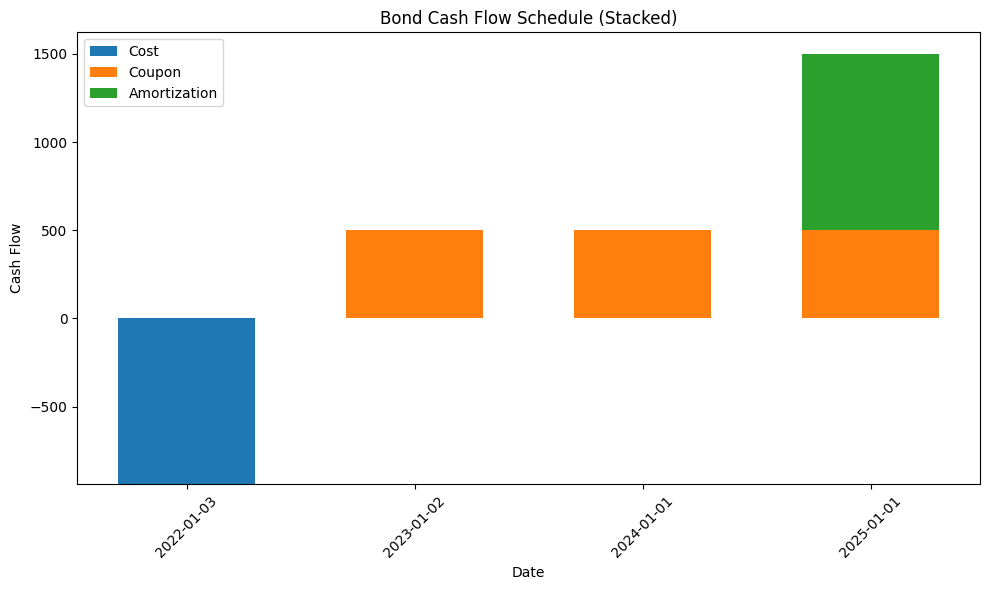

None


In [10]:
from pyfian.fixed_income.bond import BulletBond


bond = BulletBond("2020-01-01", "2025-01-01", 50, 1, notional=1000)

print(bond.cash_flows("2022-01-01"))
print(bond.plot_cash_flows(valuation_date="2022-01-01", bond_price=940))

## Dollar Value of Basis Point

A basis point (often abbreviated as "bp") is a unit of measure used in finance to describe small changes in percentages, interest rates, or other financial metrics. One basis point equals 0.01%, or one-hundredth of a percentage point. For example, 100 basis points equal 1% (100 × 0.01% = 1%).

The dollar value of a basis point (DVBP or DV01, "dollar value of a 1 basis point move") measures how much the value of a financial instrument (like a bond, loan, or swap) changes when the interest rate shifts by one basis point. It quantifies the sensitivity of the instrument's price to a small change in interest rates.

In [11]:
bond.dv01(yield_to_maturity=5, bond_price=940, valuation_date="2022-01-01")

np.float64(-0.126737963695291)

## Duration

### Duration of a Zero Coupon Bond

The duration of a bond represents how sensitive a bond price is to changes in the interest rate. We can formulate this mathmaticatically as: 

$$D = \frac{dP}{dr} \frac{1}{P}$$

Let $Z(t,T)$ be the price a zero coupon bond, then the duration of the bond will be: 

$$ D = \frac{d Z(t,T)}{dr} \frac{1}{Z(t,T)} = - \frac{1}{Z(t,T)} \left(-(T-t) e^{-r (T-t)} \right) = T-t$$

So in the case of a zero coupon bond the duration is simply the time to maturity, therefore the name of duration. 

### Macaulay Duration

Consider a security with price: 

$$P = \sum _{j=1}^n \frac{c/2}{\left(1 + \frac{y}{2}\right)^j} + \frac{100}{\left( 1 + \frac{y}{2}\right)^n}$$

The Macaulay Duration is: 

$$D^{MC} = - \frac{1 + \frac{y}{2}}{P}  \frac{dP}{dy}$$

### Modified Duration

Plugging the equation of Macaulay duration into the expression for the duration of a bond we obtain: 

$$MD = \frac{D^{MC}}{1 + \frac{y}{2}}$$

### Duration

Let's say we wanted to find the duration for any bullet bond. We can decompose the bond into a portfolio of zero coupon bonds and then find the duration of the portfolio as a weighted average: 

$$D_\pi = w_1 D_1 + w_2 D_2$$
$$w_i = \frac{N_i P_i}{\Pi}$$

In [12]:
bond_zero_coupon = BulletBond(
    "2020-01-01",
    "2025-01-01",
    cpn=0,
    cpn_freq=0,
)

print(bond_zero_coupon.modified_duration(yield_to_maturity=5))

5.002739725967517


## Convexity

### What is Convexity?

Convexity measures the curvature in the relationship between a bond's price and its yield, capturing the non-linear sensitivity of the bond price to changes in interest rates. While duration provides a linear approximation of price changes, convexity accounts for the fact that the price-yield relationship is curved, improving the accuracy of price change predictions, especially for larger yield shifts.

Mathematically, convexity is defined as the second derivative of the bond price with respect to the yield, scaled by the bond price:

$$ C = \frac{1}{P} \frac{d^2P}{dy^2} $$

where ( P ) is the bond price, and ( y ) is the yield.

### Convexity of a Zero Coupon Bond

For a zero coupon bond with price ( Z(t,T) = e^{-r (T-t)} ), where ( r ) is the interest rate and ( T-t ) is the time to maturity, we can calculate the convexity as follows:

$$ \frac{dZ}{dr} = -(T-t) e^{-r (T-t)} $$

$$ \frac{d^2Z}{dr^2} = (T-t)^2 e^{-r (T-t)} $$

$$ C = \frac{1}{Z(t,T)} \frac{d^2Z}{dr^2} = \frac{(T-t)^2 e^{-r (T-t)}}{e^{-r (T-t)}} = (T-t)^2 $$

Thus, for a zero coupon bond, the convexity is the square of the time to maturity.

### Convexity for a Coupon-Bearing Bond

Consider a bond with price:

$$ P = \sum_{j=1}^n \frac{c/2}{\left(1 + \frac{y}{2}\right)^j} + \frac{100}{\left(1 + \frac{y}{2}\right)^n} $$

where ( c ) is the annual coupon rate, ( y ) is the yield, and ( n ) is the number of periods. The convexity is:

$$ C = \frac{1}{P} \frac{1}{\left(1 + \frac{y}{2}\right)^2} \sum_{j=1}^n \frac{j (j+1) (c/2)}{\left(1 + \frac{y}{2}\right)^j} + \frac{n (n+1) (100)}{\left(1 + \frac{y}{2}\right)^{n+2}} $$

### Portfolio Convexity

For a portfolio of bonds, the convexity is the weighted average of the individual bonds' convexities:

$$ C_\pi = \sum_i w_i C_i $$

where ( $w_i = \frac{N_i P_i}{\Pi}$ ), ( $N_i$ ) is the number of bonds, ( $P_i$ ) is the price of bond ( $i $), and ( $\Pi$ ) is the total portfolio value.

In [13]:
bond_zero_coupon = BulletBond(
    "2020-01-01",
    "2025-01-01",
    cpn=0,
    cpn_freq=0,
)

print(bond_zero_coupon.convexity(yield_to_maturity=10))

30.0301444916812


In [14]:
bond_zero_coupon = BulletBond(
    "2020-01-01",
    "2025-01-01",
    cpn=0,
    cpn_freq=0,
    notional=100,
    valuation_date="2020-01-01",
    yield_to_maturity=0.1,
)
print(bond_zero_coupon._bond_price)

62.075920690313055


In [15]:
duration = bond_zero_coupon.modified_duration()
duration

4.547945205479452

In [16]:
convexity = bond_zero_coupon.convexity()
convexity

24.81830123338849

In [17]:
(
    bond_zero_coupon.price_from_yield(yield_to_maturity=0.1001)
    / bond_zero_coupon.price_from_yield(yield_to_maturity=0.100)
    - 1
)

-0.00045467045536962125

In [18]:
dr = 0.0001
-duration * dr + convexity / 2 * (dr) ** 2

-0.00045467042904177824